In [1]:
from PIL import Image

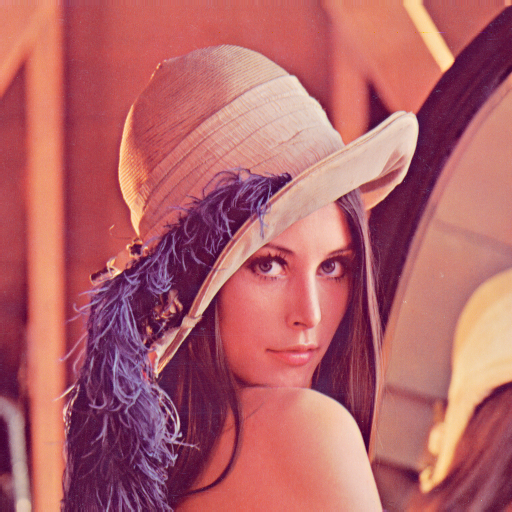

In [2]:
image = Image.open("assets/lenna.png")
image

In [3]:
import numpy as np
import torch as tch
from torch import nn
from torch.nn import functional as F

In [4]:
dev = tch.device("cuda:0")

In [6]:
from nerfpg import grid

grid((4, 4), dev)

tensor([[[0.0000, 0.0000],
         [0.0000, 0.3333],
         [0.0000, 0.6667],
         [0.0000, 1.0000]],

        [[0.3333, 0.0000],
         [0.3333, 0.3333],
         [0.3333, 0.6667],
         [0.3333, 1.0000]],

        [[0.6667, 0.0000],
         [0.6667, 0.3333],
         [0.6667, 0.6667],
         [0.6667, 1.0000]],

        [[1.0000, 0.0000],
         [1.0000, 0.3333],
         [1.0000, 0.6667],
         [1.0000, 1.0000]]], device='cuda:0')

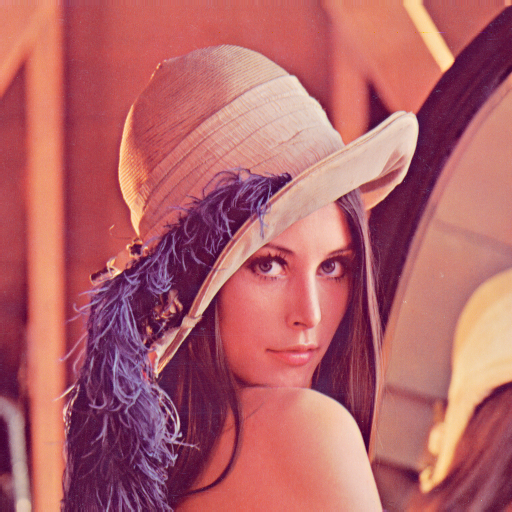

In [7]:
from nerfpg import image_to_tensor, tensor_to_image

img = image_to_tensor(image, dev)
tensor_to_image(img)

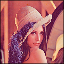

In [8]:
def sample(img: tch.Tensor, coords: tch.Tensor) -> tch.Tensor:
    return (
        F.grid_sample(
            img.unsqueeze(0),
            (coords * 2.0 - 1.0).unsqueeze(0).unsqueeze(0),
            align_corners=False,
        )
        .squeeze(0)
        .squeeze(1)
    )


shape = (64, 64)
tensor_to_image(
    sample(img, grid(shape, dev).transpose(0, 1).flatten(0, 1)).reshape((-1, *shape))
)

In [9]:
def infer(model: nn.Module, res: tuple[int, int], dev: tch.device) -> Image:
    model.train(False)
    xs = grid(res, dev).transpose(0, 1).flatten(0, 1)
    ys = model.forward(xs)
    out = F.sigmoid(ys).transpose(0, 1).reshape((-1, *res))
    return tensor_to_image(out)

In [10]:
from nerfpg import encode_coord

encode_coord((tch.arange(10) / 9.0).unsqueeze(1), 4)

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.9397,  0.7660,  0.5000,  0.1736],
        [ 0.7660,  0.1736, -0.5000, -0.9397],
        [ 0.5000, -0.5000, -1.0000, -0.5000],
        [ 0.1736, -0.9397, -0.5000,  0.7660],
        [-0.1736, -0.9397,  0.5000,  0.7660],
        [-0.5000, -0.5000,  1.0000, -0.5000],
        [-0.7660,  0.1736,  0.5000, -0.9397],
        [-0.9397,  0.7660, -0.5000,  0.1736],
        [-1.0000,  1.0000, -1.0000,  1.0000]])

In [41]:
from typing import Callable

class Lambda(nn.Module):
    def __init__(self, func: Callable[[tch.Tensor], tch.Tensor]):
        super().__init__()
        self.func = func
    
    def forward(self, x: tch.Tensor) -> tch.Tensor:
        return self.func(x)

In [82]:
dim = 256
n_modes = 256
model = nn.Sequential(
    Lambda(lambda x: encode_coord(x, n_modes)),
    nn.Linear(2 * n_modes, dim),
    nn.ReLU(),
    nn.Linear(dim, dim),
    nn.ReLU(),
    nn.Linear(dim, dim),
    nn.ReLU(),
    nn.Linear(dim, 3),
)
model = model.to(dev)

In [83]:
batch_size = 1024
optim = tch.optim.AdamW(model.parameters(), lr=1e-3)

'9: 0.0001923808886203915'

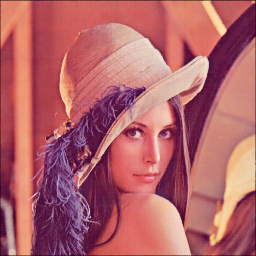

In [86]:
from IPython.display import display

display_loss = display(display_id=True)
display_sample = display(display_id=True)

epoch_steps = 1000
for epoch in range(10):
    model.train(True)

    total_loss = 0.0
    for i in range(epoch_steps):
        model.zero_grad()

        xs = tch.rand((batch_size, 2), device=dev)
        ys = F.sigmoid(model.forward(xs)).transpose(0, 1)

        ref = sample(img, xs)
        loss = F.mse_loss(ys, ref)
        total_loss += loss.numpy(force=True)

        loss.backward()
        optim.step()

    total_loss /= epoch_steps
    display_loss.update(f"{epoch}: {total_loss}")

    display_sample.update(infer(model, (256, 256), dev))

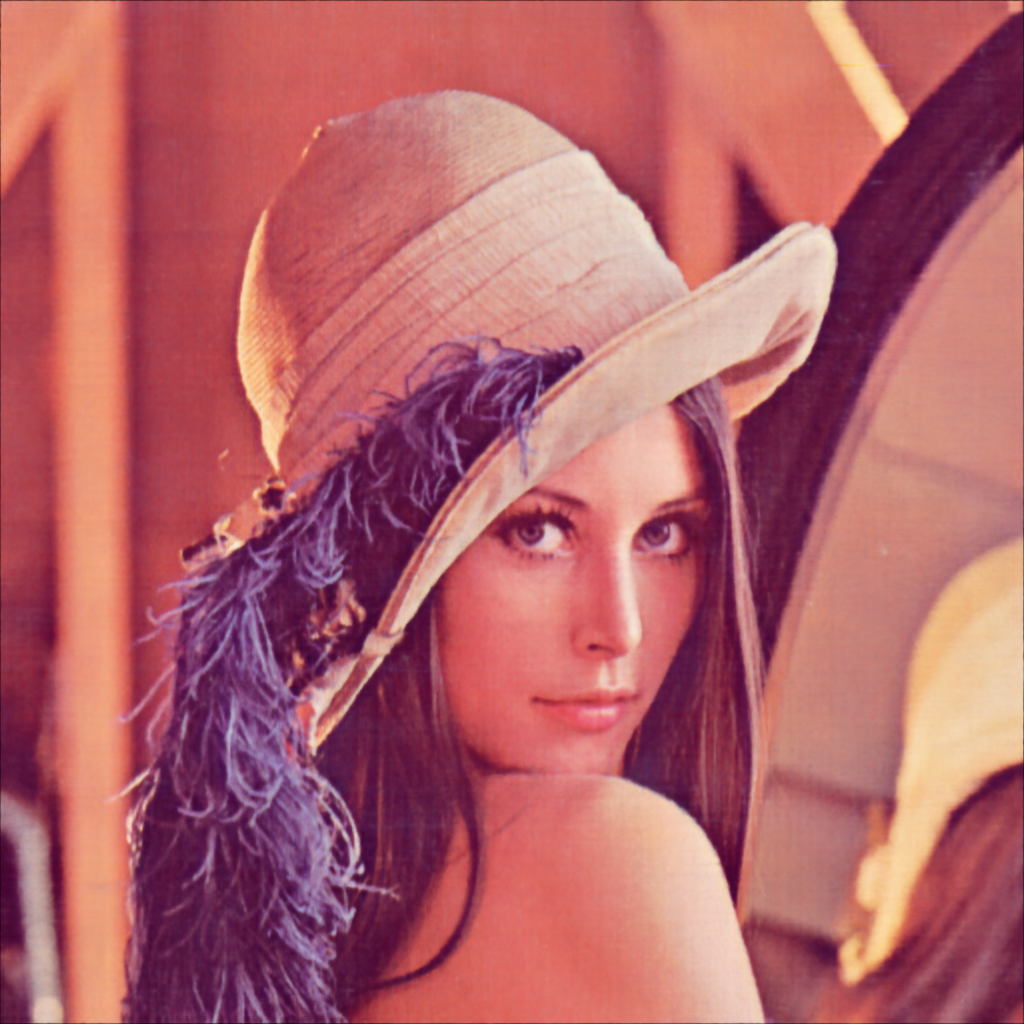

In [87]:
display(infer(model, (1024, 1024), dev))